c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 Analyzing image: C:\Users\HP\Documents\GitHub\-Soil-Organic-Matter-Estimation\dataset\Soil types\Yellow Soil\2.jpg

 Average Soil Color Values:
H = 0.10, S = 0.82, I = 0.37

 Soil Color Percentages:
Cluster 0: 9.3%
Cluster 1: 21.6%
Cluster 2: 69.1%

 Cluster Classification:
Cluster 0: Light Soil (Low Organic Matter) (I = 0.68)
Cluster 1: Dark Soil (High Organic Matter) (I = 0.36)
Cluster 2: Light Soil (Low Organic Matter) (I = 0.54)

 Soil Intensity Analysis:
 Dark Soil: 42.73% (High Organic Matter)
 Light Soil: 57.27% (Low Organic Matter)
🔹 Accuracy (Based on Silhouette Score): 33.57%



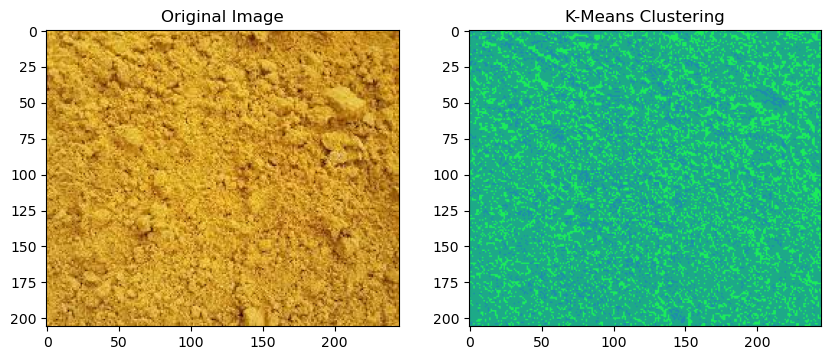

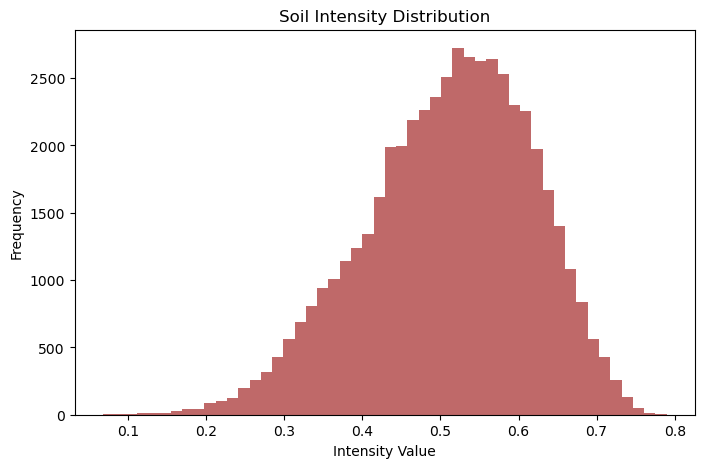

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ฟังก์ชันแปลง RGB → HSI
def rgb_to_hsi(image):
    """ แปลงภาพจาก RGB เป็น HSI Color Space """
    image = image.astype(np.float32) / 255.0  # Normalize RGB
    r, g, b = cv2.split(image)

    # คำนวณ Intensity
    I = (r + g + b) / 3

    # คำนวณ Saturation
    min_rgb = np.minimum(np.minimum(r, g), b)
    S = 1 - (min_rgb / (I + 1e-6))  # ป้องกันหารด้วย 0

    # คำนวณ Hue
    num = 0.5 * ((r - g) + (r - b))
    den = np.sqrt((r - g) ** 2 + (r - b) * (g - b)) + 1e-6  # ป้องกันหารด้วย 0
    theta = np.arccos(num / den)

    H = np.where(b > g, 2 * np.pi - theta, theta)
    H = H / (2 * np.pi)  # ปรับให้ค่า H อยู่ในช่วง 0-1

    hsi_image = cv2.merge([H, S, I])
    return hsi_image

# ฟังก์ชันโหลดและแปลงภาพ
def load_and_convert_image(image_path):
    """ โหลดและแปลงภาพเป็น RGB และ HSI """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"❌ ไม่พบไฟล์: {image_path}")

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsi_image = rgb_to_hsi(image)
    return image, hsi_image

# ฟังก์ชันลบพื้นหลัง
def remove_background(image):
    """ กำจัดพื้นหลังของดินด้วย Otsu's Thresholding """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # ปรับปรุงผลลัพธ์ด้วย Morphological Operations
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # ใช้ mask เพื่อลบพื้นหลังออกจากภาพ
    result = cv2.bitwise_and(image, image, mask=mask)
    return result, mask

# ฟังก์ชันวิเคราะห์ค่าเฉลี่ยของ HSI
def analyze_soil_color(hsi_image, mask):
    """ คำนวณค่าเฉลี่ยของ H, S, I (HSI Color Space) """
    h, s, i = cv2.split(hsi_image)
    mean_H = np.mean(h[mask > 0])
    mean_S = np.mean(s[mask > 0])
    mean_I = np.mean(i[mask > 0])
    return mean_H, mean_S, mean_I

# ฟังก์ชัน K-Means Clustering
def kmeans_clustering(hsi_image, k=3):
    """ ใช้ K-Means Clustering แบ่งระดับสีดินใน HSI """
    pixels = hsi_image.reshape((-1, 3))
    pixels = np.float32(pixels)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(hsi_image.shape)

    return segmented_image, labels, centers

# ฟังก์ชันคำนวณเปอร์เซ็นต์ของแต่ละสี
def calculate_color_percentage(labels, k):
    """ คำนวณเปอร์เซ็นต์ของแต่ละกลุ่มสีดิน """
    unique, counts = np.unique(labels, return_counts=True)
    total_pixels = np.sum(counts)
    percentages = {f'Cluster {i}': (counts[i] / total_pixels) * 100 for i in range(k)}
    return percentages

# ฟังก์ชันวิเคราะห์ดินเข้ม / ดินอ่อน
def classify_soil_intensity(hsi_image, threshold=0.5):
    """ แยกดินเข้ม/อ่อน โดยใช้ค่า Intensity """
    _, _, intensity = cv2.split(hsi_image)
    dark_soil_ratio = np.sum(intensity < threshold) / intensity.size * 100
    light_soil_ratio = 100 - dark_soil_ratio
    return dark_soil_ratio, light_soil_ratio

# ฟังก์ชันสรุปว่าดินอยู่ใน Clustering ไหน
def classify_clusters(centers):
    """ จำแนกดินแต่ละกลุ่มว่าเป็นดินเข้มหรือดินอ่อน """
    cluster_types = []
    for i, center in enumerate(centers):
        H, S, I = center
        soil_type = "Dark Soil (High Organic Matter)" if I <= 0.5 else "Light Soil (Low Organic Matter)"
        cluster_types.append(f"Cluster {i}: {soil_type} (I = {I:.2f})")
    return cluster_types

# ฟังก์ชันแสดงผล Histogram
def plot_histogram(hsi_image):
    """ แสดง Histogram ของค่า Intensity """
    _, _, intensity = cv2.split(hsi_image)
    plt.figure(figsize=(8,5))
    plt.hist(intensity.ravel(), bins=50, color='brown', alpha=0.7)
    plt.xlabel("Intensity Value")
    plt.ylabel("Frequency")
    plt.title("Soil Intensity Distribution")
    plt.show()
    
# ฟังก์ชันวัดประสิทธิภาพของ K-Means
def evaluate_kmeans_silhouette(hsi_image, labels):
    pixels = hsi_image.reshape((-1, 3))
    return silhouette_score(pixels, labels)

# กำหนดพาธรูปภาพ

# กำหนดพาธรูปภาพ
BASE_PATH = os.path.normpath("C:/Users/HP/Documents/GitHub/-Soil-Organic-Matter-Estimation/dataset/Soil types")
SOIL_TYPE = "Yellow Soil"
IMAGE_NAME = "2.jpg"
IMAGE_PATH = os.path.join(BASE_PATH, SOIL_TYPE, IMAGE_NAME)

# วิเคราะห์ภาพดิน
original, hsi_image = load_and_convert_image(IMAGE_PATH)
clean_image, mask = remove_background(original)
mean_H, mean_S, mean_I = analyze_soil_color(hsi_image, mask)
segmented_image, labels, centers = kmeans_clustering(hsi_image, k=3)
percentages = calculate_color_percentage(labels, k=3)
dark_soil_ratio, light_soil_ratio = classify_soil_intensity(hsi_image)
cluster_analysis = classify_clusters(centers)  
silhouette = evaluate_kmeans_silhouette(hsi_image, labels)

# แสดงผล
print(f"\n Analyzing image: {IMAGE_PATH}\n")
print(f" Average Soil Color Values:\nH = {mean_H:.2f}, S = {mean_S:.2f}, I = {mean_I:.2f}\n")

print(" Soil Color Percentages:")
for cluster, percent in percentages.items():
    print(f"{cluster}: {percent:.1f}%")

print("\n Cluster Classification:")
for cluster_info in cluster_analysis:
    print(cluster_info)

print(f"\n Soil Intensity Analysis:")
print(f" Dark Soil: {dark_soil_ratio:.2f}% (High Organic Matter)")
print(f" Light Soil: {light_soil_ratio:.2f}% (Low Organic Matter)")

accuracy = silhouette * 100
print(f"\naccuracy (Based on Silhouette Score): {accuracy:.2f}%\n")

# แสดงภาพ + Histogram
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("K-Means Clustering")
plt.show()

plot_histogram(hsi_image)